# Fast Food Marketing Campaign A\B Test

![fastfood](https://images.unsplash.com/photo-1512152272829-e3139592d56f?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=870&q=80)

### Problem Statement
A fast-food chain plants to add a new item to its menu. However, they are still undecided between three possible marketing campaigs for promoting the new product. In order to determine which promotion has the gratest effect on sales, the new item is introduced at locations in several randomly selcted markets. A different promotions is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

In this project, we going to develop a A\B Test to detect differences statistically significant among the Promotions, and finding which (promotion) has the greatest effect on sales.

Author: Luis Fernando Salazar S.

Date: 29/09/2022

### Install and Inport libraries 

In [ ]:
!pip install bioinfokit

In [2]:
# Import libraries
import warnings 
warnings.simplefilter(action = "ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
from statsmodels.graphics.gofplots import qqplot

import numpy as np
import pandas as pd
from sklearn.preprocessing import Normalizer
import scipy
from scipy.stats import boxcox
from scipy.stats import shapiro, levene

import statsmodels.api as sm
from statsmodels.stats.power import FTestAnovaPower
from statsmodels.formula.api import ols

### Get the dataset

In [3]:
## Get data 
filepath = "C:/Users/User/Desktop/ML_Project/Fast Food Marketing Campaign AB Test/WA_Marketing-Campaign.csv"
df = pd.read_csv(filepath)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


### EDA

In [3]:
## shape 
print(f"Data Shape: {df.shape}")
df.head()

Data Shape: (548, 7)


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [4]:
## Main summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MarketID,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
LocationID,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
AgeOfStore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
Promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
SalesInThousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


In [5]:
# categorical variables
df.describe(include = "object")

,MarketSize
count,548
unique,3
top,Medium
freq,320


#### Distribution of the Variables

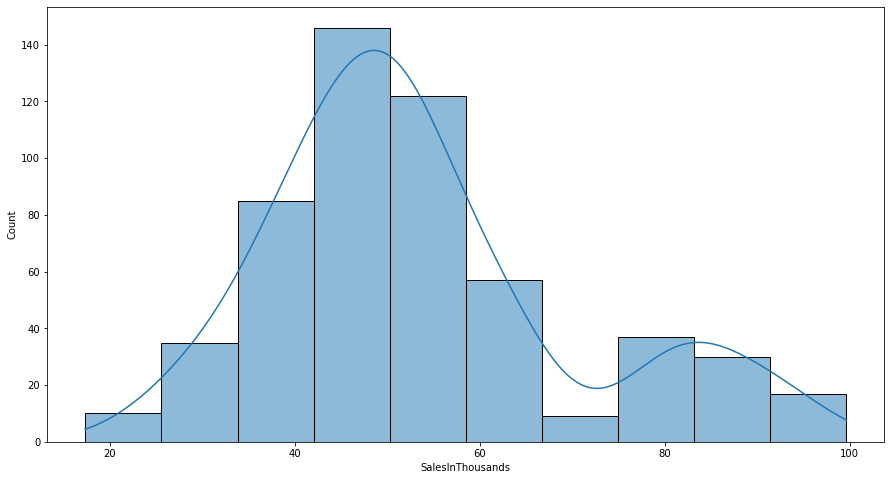

In [6]:
## Sales distribution
plt.figure(figsize = (15, 8))
sns.histplot(data = df, 
             x = "SalesInThousands", 
             bins = 10, kde = True);

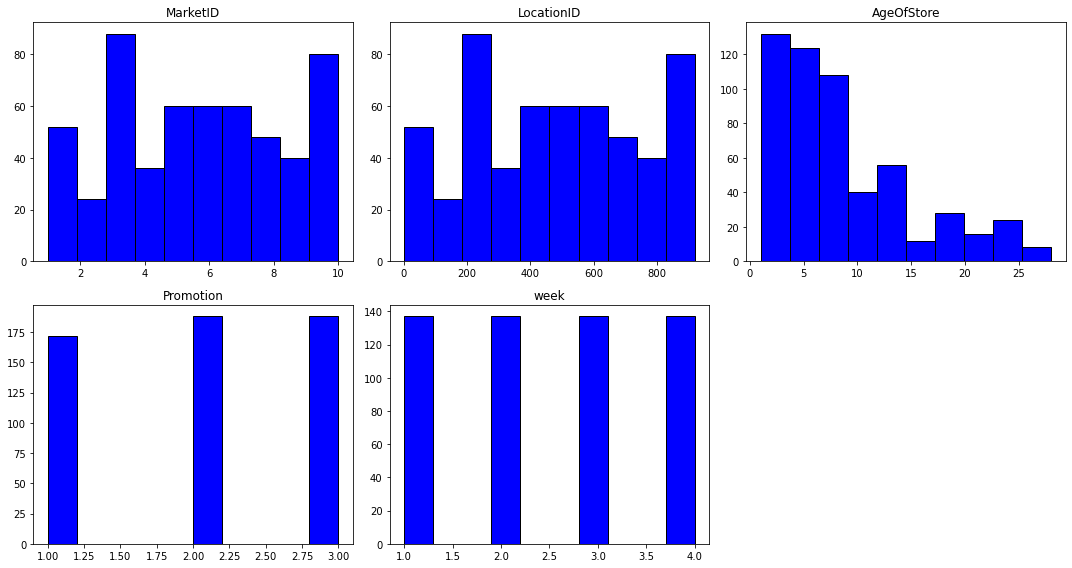

In [7]:
## variable Distributions
df.drop(columns = "SalesInThousands").hist(bins = 10,
                                           figsize = (15, 8),
                                           grid = False,
                                           layout = (-1, 3),
                                           color = "blue",
                                           edgecolor = "black",
                                           )
plt.tight_layout();

#### Visual Analysis - Market size

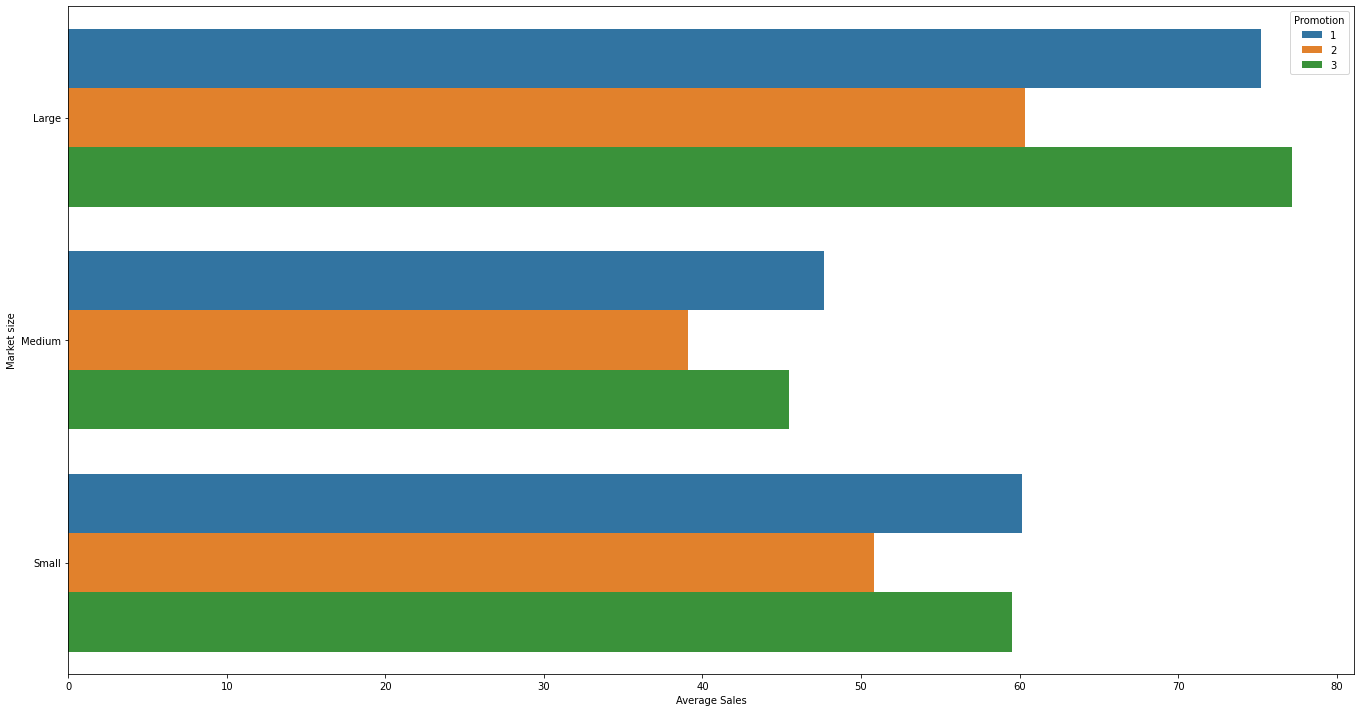

In [8]:
## Group by market size and promotions
group_marke_size = (
    df
    .groupby(["MarketSize", "Promotion"])["SalesInThousands"]
    .mean()
    .to_frame()
    .reset_index()
)


# Barplot
fig, ax = plt.subplots(figsize = (19,10))

sns.barplot(data = group_marke_size,
            x = 'SalesInThousands',
            y = 'MarketSize',
            hue = 'Promotion',
            ax = ax
            )

ax.set(xlabel = 'Average Sales',
       ylabel = 'Market size',
)

plt.tight_layout();

#### Visual Analysis - Weeks 

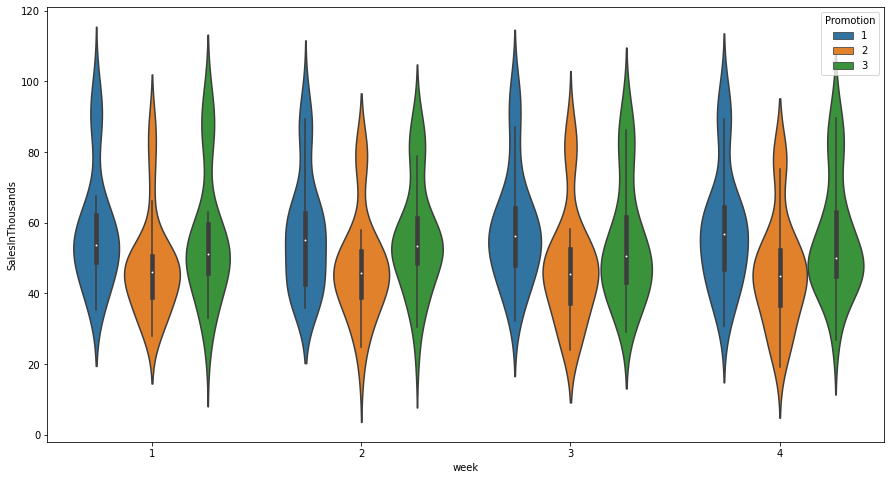

In [9]:
# Continue variable
y_value = "SalesInThousands"

# violinplot plot
fig, ax = plt.subplots(figsize = (15,8))
sns.violinplot(data = df,
              x = "week",
              y = y_value,
              hue = "Promotion",
              ax = ax);

#### Visual Analysis - Promotions

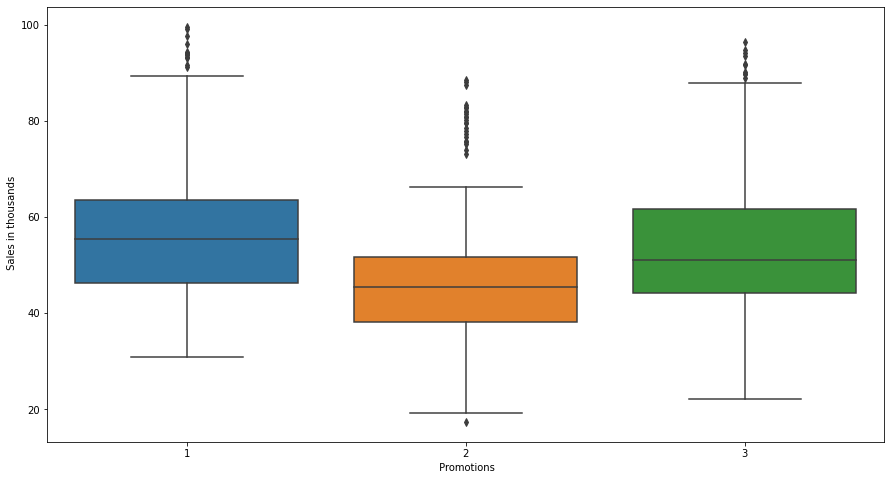

In [10]:
# boxplot plot
fig, ax = plt.subplots(figsize = (15,8))
sns.boxplot(data = df,
              x = "Promotion",
              y = y_value,
              ax = ax)

ax.set_xlabel(" Promotions")
ax.set_ylabel(" Sales in thousands");

### Data preprocessing

In [4]:
## subset of data 
data = df[["Promotion", "SalesInThousands"]].rename(columns = {"Promotion": "treatments","SalesInThousands":"sales"},                                                  )
data.head(4)

,treatments,sales
0,3,33.73
1,3,35.67
2,3,29.03
3,3,39.25


#### BoxCox

In [12]:
## BoxCox transformatins over the target variable
target_box = boxcox(data["sales"])
data_bc = target_box[0]
lam = target_box[1]
print("lambda : ", lam)

lambda :  0.02038728629268403


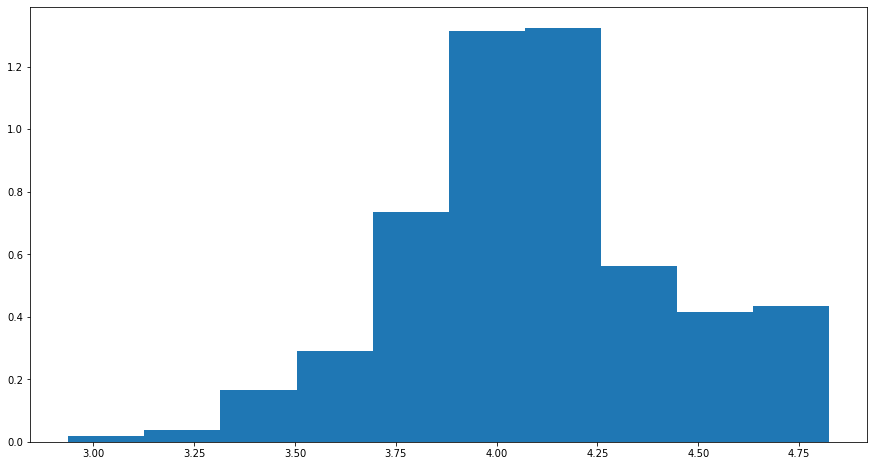

In [13]:
## Distribution after apply boxcox 
plt.figure(figsize =(15,8))
plt.hist(data_bc, bins = 10, density = True);

In [5]:
# Mapping treataments/factors
dict_map = {
    1 : "Promotion_1",
    2 : "Promotion_2",
    3 : "Promotion_3"
}

data["treatments"] = data["treatments"].map(dict_map)
# Add columns new target variable
#data["sales_tran"] = data_bc
## Remove the old target variable
#data.drop(columns = "sales", inplace = True)
#head 
data.head(4)

,treatments,sales
0,Promotion_3,33.73
1,Promotion_3,35.67
2,Promotion_3,29.03
3,Promotion_3,39.25


In [15]:
data["treatments"].value_counts()

Promotion_3    188
Promotion_2    188
Promotion_1    172
Name: treatments, dtype: int64

### Experimental design

#### Hypothesis 

- Null Hypothesis: Sales mean in the three promotions are equals (no variations between group).

- Alternative Hypothesis: A least, one promotion sales' mean is different from other groups.

#### Paramentric

##### Anova (one-way)

Hypothesis:
 - H0: μ1=μ2=…=μp
 - H1: All μ are not equal
 
Assumtions:

- Normality : residuals are approximately normally distributed
- Homoscedasticity or Homogeneity : the variances of residuals are equal between treatment group (there is not changes)
- Indepency : residuals are independent
 

In [16]:
## Fit model
model = ols("sales_tran ~ C(treatments)", data = data).fit()
# Anova table summary
anova_table = sm.stats.anova_lm(model, type = 2)
# Summary 
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),2.0,5.383328,2.691664,26.48523,1.053950e-11
Residual,545.0,55.387729,0.101629,NaN,NaN


In [17]:
## Anova with bionfokit library
from bioinfokit.analys import stat
# Intance of stat
stats_anov = stat()
#Anova
stats_anov.anova_stat(
    df = data,
    res_var = "sales_tran",
    xfac_var = "treatments",
    anova_model = "sales_tran ~ C(treatments)"
)
## summary
stats_anov.anova_summary

,df,sum_sq,mean_sq,F,PR(>F)
C(treatments),2.0,5.383328,2.691664,26.48523,1.053950e-11
Residual,545.0,55.387729,0.101629,NaN,NaN


##### Tukey test (Post-Hoc Test)

In [18]:
from bioinfokit.analys import stat

## Tukey- Kramer test 
tukey = stat()
tukey.tukey_hsd(df=data, 
                res_var='sales_tran', 
                xfac_var='treatments', 
                anova_model='sales_tran ~ C(treatments)')

tukey.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Promotion_3,Promotion_2,0.174722,0.097445,0.251999,7.514803,0.001000
1,Promotion_3,Promotion_1,0.058585,-0.020469,0.137638,2.463098,0.190856
2,Promotion_2,Promotion_1,0.233306,0.154253,0.312360,9.809008,0.001000


##### Test ANOVA assumptions

###### Normality 

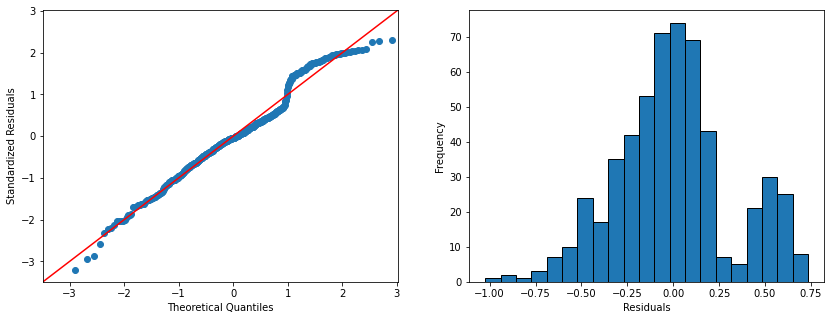

In [19]:
## Visual normality test
## QQplot
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
# Satandarize residual 
qqplot(stats_anov.anova_std_residuals, line = "45", ax = ax[0])
ax[0].set_xlabel("Theoretical Quantiles")
ax[0].set_ylabel("Standardized Residuals")
# histogram
ax[1].hist(stats_anov.anova_model_out.resid, bins = "auto", histtype = "bar", ec = "k")
ax[1].set_xlabel("Residuals")
ax[1].set_ylabel('Frequency');

##### Shapiro normality test

In [20]:
## Shapiro normality test
sha = scipy.stats.shapiro(model.resid) 
sha

ShapiroResult(statistic=0.9784872531890869, pvalue=3.233699885640817e-07)

#### Observations

- According to the p-value (<0.05) from the Shapiro test, the ANOVA test does not satisfy the normality assumption. therefore, one-way ANOVA is not the most suitable test option for finding significant differences among the evaluated groups. We should a non paramentric test, in this case a Kruskal - Wallis test.

#### Non-Parametric

##### Kruskal - Wallis Test (Anova non parametric)

Hypothesis:
 - H0: μ1=μ2=…=μp
 - H1: All μ are not equal

In [6]:
krus_test = scipy.stats.kruskal(
    data.loc[data["treatments"] == "Promotion_1"]["sales"],
    data.loc[data["treatments"] == "Promotion_2"]["sales"],
    data.loc[data["treatments"] == "Promotion_3"]["sales"]
)
print(krus_test)

KruskalResult(statistic=53.29475169322799, pvalue=2.6741866266697816e-12)


##### Observations

- According to P-value(2.6741866266697816e-12 < 0.05) from the Kruskal-Wallis test, we can say that there is sufficient statistical evidence to reject the hypothesis null. Therefore, the differences among the groups are statistically significants.

- To understand where are specific differences among the distributions from the groups, we going to make a Mann-Whitney (due to the samples among the group being unbalanced) post hoc test.

##### Mann-Whitney test (Post-hoc test)

In [21]:
##
Post_hoc = pd.DataFrame()

combination = [("Promotion_1", "Promotion_2"), 
               ("Promotion_1", "Promotion_3"), 
               ("Promotion_2", "Promotion_3")]
# Computing the test
for i, j in combination: 
    Post_hoc = Post_hoc.append(pd.DataFrame(
        [list(scipy.stats.mannwhitneyu(
        x = data.loc[data["treatments"] == i]["sales"],
        y = data.loc[data["treatments"] == j]["sales"],))], columns = ["test", "p-value"]))
    
Post_hoc

,test,p-value
0,22957.5,5.845935e-12
0,18247.0,3.508410e-02
0,12093.0,1.197008e-07


##### Observations

- The results from the Mann-Whitney test suggest that all pairwise comparations for treatments reject the null hypothesis (p-value < 0.05) and indicates statistically significant differences. In other words, the promotions affect the sales of diffrent manners. In this sense, **promotion with a higher effect was promotion 1**.